In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from datetime import datetime, timedelta

/Users/jteruya/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Matlab Plot Settings

In [2]:
# Display Plot within Jupyter Notebook
%matplotlib inline
# Default Plot Size
plt.rcParams['figure.figsize'] = [10, 10]

## Index Data

In [3]:
# Helper Function
def download_data(ticker, start, end):
    return yf.download(ticker, start, end)

# Start and End Dates for Ticker Data
start_date = "2018-01-01"
end_date = "2021-01-11"
# List of Indices to Retrieve Data
indices = ["^VIX", "^GSPC", "^DJI", "^TNX", "DX-Y.NYB", "GLD", "TIP", "VNQ"]
# List of lists
indices_data = [download_data(index, start_date, end_date) for index in indices]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Percent Movement Per Index
Calculate the % change for each day

In [4]:
# Previous Closing
def previous_close(df):
    df['Previous Close'] = df['Close'].shift(1)
    return df

# Percent Movement Helper Function
def market_movement(row):
    return (row['Close'] - row['Previous Close'])/row['Previous Close']

# Get Previous Close to Account for Futures
indices_data_prev = [previous_close(df) for df in indices_data]

# Apply helper function to all index dataframes
percent_movement = [index.apply(market_movement, axis=1) for index in indices_data_prev]

## Visualize Percent Market Per Day

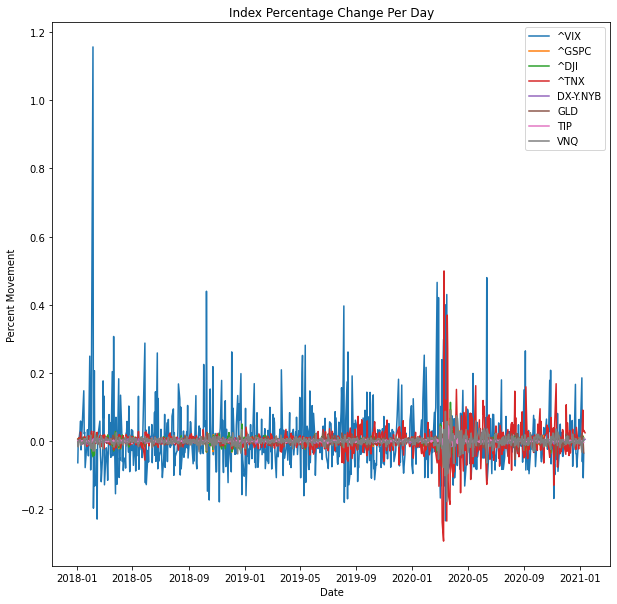

In [5]:
for x in range(len(indices)):
    plt.plot(percent_movement[x], label=indices[x])
plt.xlabel('Date')
plt.ylabel('Percent Movement')
plt.title('Index Percentage Change Per Day')
plt.legend()
plt.show()

## Create Daily Dataframe for Correlation Calculations

In [6]:
# Inital Correlation Dataframe
all_indices_df = pd.concat(percent_movement, axis=1)
all_indices_df.columns = [index[1:] + " Percent Movement" for index in indices]
original_columns = all_indices_df.columns
all_indices_df['Day'] = all_indices_df.index

# Add Timeshifts (by Day)
max_shift = 4
for shift in range(1, max_shift):
    for column in original_columns:
        all_indices_df[column + " + " + str(shift) + " Day Shift"] = all_indices_df[column].shift(-shift)

# Direction Change
all_indices_df['GSPC Same Direction'] = (all_indices_df['GSPC Percent Movement'].shift(1) > 0)^(all_indices_df['GSPC Percent Movement'] < 0)
all_indices_df['VIX Same Direction'] = (all_indices_df['VIX Percent Movement'].shift(1) > 0)^(all_indices_df['VIX Percent Movement'] < 0)
        
# Directional Streak ID
all_indices_df['GSPC Streak'] = 0
all_indices_df['VIX Streak'] = 0

all_indices_df['GSPC Streak'] = all_indices_df.apply(lambda x: 1 if not(x['GSPC Same Direction']) else x['GSPC Streak'], axis=1).cumsum()
all_indices_df['VIX Streak'] = all_indices_df.apply(lambda x: 1 if not(x['VIX Same Direction']) else x['VIX Streak'], axis=1).cumsum()

# Count the consecutive days of a particular streak
all_indices_df['GSPC Streak Consecutive Days'] = all_indices_df.groupby("GSPC Streak")['Day'].rank("dense", ascending=True)
all_indices_df['VIX Streak Consecutive Days'] = all_indices_df.groupby("VIX Streak")['Day'].rank("dense", ascending=True)

# Dependent Variable
all_indices_df['VIX Same Direction Next Day'] = all_indices_df['VIX Same Direction'].shift(-1)

# Correlations on Columns
all_indices_df.tail(10)

,VIX Percent Movement,GSPC Percent Movement,DJI Percent Movement,TNX Percent Movement,X-Y.NYB Percent Movement,LD Percent Movement,IP Percent Movement,NQ Percent Movement,Day,VIX Percent Movement + 1 Day Shift,...,LD Percent Movement + 3 Day Shift,IP Percent Movement + 3 Day Shift,NQ Percent Movement + 3 Day Shift,GSPC Same Direction,VIX Same Direction,GSPC Streak,VIX Streak,GSPC Streak Consecutive Days,VIX Streak Consecutive Days,VIX Same Direction Next Day
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-28,0.007896,0.008723,0.006758,-0.023037,-0.000774,-0.003629,0.000707,0.005961,2020-12-28,0.063594,...,0.003714,0.002120,0.009629,True,False,393,398,3.0,1.0,True
2020-12-29,0.063594,-0.002227,-0.002246,0.002144,-0.003653,0.003642,-0.000471,-0.008533,2020-12-29,-0.013432,...,0.022258,0.001097,-0.032497,False,True,394,398,1.0,2.0,False
2020-12-30,-0.013432,0.001342,0.002436,-0.009626,-0.004222,0.007655,0.000786,0.005498,2020-12-30,-0.000878,...,0.002962,-0.000313,0.001460,False,False,395,399,1.0,1.0,True
2020-12-31,-0.000878,0.006439,0.006476,-0.009719,0.003459,0.003714,0.002120,0.009629,2020-12-31,0.185494,...,-0.016241,-0.002975,0.001701,True,True,395,399,2.0,2.0,False
2021-01-04,0.185494,-0.014755,-0.012500,0.000000,-0.000667,0.022258,0.001097,-0.032497,2021-01-04,-0.060437,...,-0.002335,-0.000628,-0.001941,False,False,396,400,1.0,1.0,False
2021-01-05,-0.060437,0.007083,0.005549,0.041439,-0.004895,0.002962,-0.000313,0.001460,2021-01-05,-0.010655,...,-0.034210,-0.003928,0.009724,False,False,397,401,1.0,1.0,True
2021-01-06,-0.010655,0.005710,0.014405,0.091100,0.001006,-0.016241,-0.002975,0.001701,2021-01-06,-0.107698,...,NaN,NaN,NaN,True,True,397,401,2.0,2.0,True
2021-01-07,-0.107698,0.014847,0.006868,0.027831,0.003351,-0.002335,-0.000628,-0.001941,2021-01-07,-0.036209,...,NaN,NaN,NaN,True,True,397,401,3.0,3.0,True
2021-01-08,-0.036209,0.005492,0.001831,0.031746,0.002672,-0.034210,-0.003928,0.009724,2021-01-08,NaN,...,NaN,NaN,NaN,True,True,397,401,4.0,4.0,False


## VIX Directional Model

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Categorical Label Encoder for Dependent Variable
le = preprocessing.LabelEncoder()

independent_variables = ['GSPC Percent Movement', 'TNX Percent Movement', 'X-Y.NYB Percent Movement', 'LD Percent Movement', 'IP Percent Movement', 'NQ Percent Movement']

X = all_indices_df[independent_variables][2:-2]
y = all_indices_df['VIX Same Direction Next Day'][2:-2]

# Fill Non null values with mean
X.fillna(X.mean(), inplace=True)

# Encode Categorical Dependent Variable
le.fit(y)
y = le.transform(y)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Train the Model
model = LogisticRegression(random_state=0).fit(X_train, y_train)

model.predict(X_test)
model.predict_proba(X_test)

# Score the Model
model.score(X_test, y_test)

0.5163398692810458

## Save Model

In [8]:
model_file_handler = open("models/vix_prediction.pl",'wb')
pickle.dump(model, model_file_handler)
model_file_handler.close()

## Prediction

In [9]:
model_file_handler = open("models/vix_prediction.pl",'rb')
model = pickle.load(model_file_handler)

In [10]:
# Prediction
base = datetime(2020,12,1)
date_list = [base - timedelta(days=x) for x in range(100)]

for date in date_list:
    date_index = date.strftime("%Y-%m-%d")
    try:
        print(date_index)
        print(model.predict_proba([all_indices_df.loc[date_index][independent_variables]]))
        print(model.predict([all_indices_df.loc[date_index][independent_variables]]))
    except:
        print("No Trading Day")
        pass
    print("\n")

2020-12-01
[[0.51263443 0.48736557]]
[0]


2020-11-30
[[0.52719048 0.47280952]]
[0]


2020-11-29
No Trading Day


2020-11-28
No Trading Day


2020-11-27
No Trading Day


2020-11-26
No Trading Day


2020-11-25
[[0.52336272 0.47663728]]
[0]


2020-11-24
[[0.51873164 0.48126836]]
[0]


2020-11-23
[[0.52011438 0.47988562]]
[0]


2020-11-22
No Trading Day


2020-11-21
No Trading Day


2020-11-20
[[0.52619755 0.47380245]]
[0]


2020-11-19
[[0.52428274 0.47571726]]
[0]


2020-11-18
[[0.52541161 0.47458839]]
[0]


2020-11-17
[[0.52603785 0.47396215]]
[0]


2020-11-16
[[0.51945373 0.48054627]]
[0]


2020-11-15
No Trading Day


2020-11-14
No Trading Day


2020-11-13
[[0.51806097 0.48193903]]
[0]


2020-11-12
[[0.5304139 0.4695861]]
[0]


2020-11-11
[[0.52273045 0.47726955]]
[0]


2020-11-10
[[0.52069805 0.47930195]]
[0]


2020-11-09
[[0.50758783 0.49241217]]
[0]


2020-11-08
No Trading Day


2020-11-07
No Trading Day


2020-11-06
[[0.51962588 0.48037412]]
[0]


2020-11-05
[[0.51891729 0.48108271

## Calculate Correlations

In [11]:
# Correlations on Columns
all_indices_df.corr(method ='pearson')

,VIX Percent Movement,GSPC Percent Movement,DJI Percent Movement,TNX Percent Movement,X-Y.NYB Percent Movement,LD Percent Movement,IP Percent Movement,NQ Percent Movement,VIX Percent Movement + 1 Day Shift,GSPC Percent Movement + 1 Day Shift,...,X-Y.NYB Percent Movement + 3 Day Shift,LD Percent Movement + 3 Day Shift,IP Percent Movement + 3 Day Shift,NQ Percent Movement + 3 Day Shift,GSPC Same Direction,VIX Same Direction,GSPC Streak,VIX Streak,GSPC Streak Consecutive Days,VIX Streak Consecutive Days
VIX Percent Movement,1.000000,-0.687486,-0.659487,-0.246377,0.001259,0.004836,0.037158,-0.452632,-0.070974,0.103736,...,0.064307,0.011016,-0.047919,-0.060715,0.078093,-0.039887,-0.023993,-0.021545,0.113356,-0.059902
GSPC Percent Movement,-0.687486,1.000000,0.977913,0.418667,-0.033097,0.058087,-0.095057,0.796307,0.133790,-0.264171,...,-0.083140,-0.015337,0.054298,0.000081,-0.031177,-0.012117,0.031464,0.030011,-0.046005,0.011571
DJI Percent Movement,-0.659487,0.977913,1.000000,0.423047,-0.045684,0.042101,-0.085708,0.797773,0.129103,-0.249670,...,-0.092883,-0.001783,0.031840,-0.006983,-0.029570,-0.008330,0.024370,0.022788,-0.045778,0.011612
TNX Percent Movement,-0.246377,0.418667,0.423047,1.000000,0.180869,-0.262417,-0.523378,0.319405,0.082568,-0.200120,...,0.009208,0.056137,0.174303,-0.029391,-0.032945,-0.001721,0.018716,0.016967,-0.039950,0.011896
X-Y.NYB Percent Movement,0.001259,-0.033097,-0.045684,0.180869,1.000000,-0.439458,-0.157627,-0.065834,0.041184,-0.117159,...,0.003470,0.095425,0.093118,0.101101,-0.124523,-0.094161,-0.057579,-0.057377,-0.101408,-0.066062
LD Percent Movement,0.004836,0.058087,0.042101,-0.262417,-0.439458,1.000000,0.330557,0.094758,-0.035003,0.075618,...,-0.104941,-0.004876,0.049689,0.042224,0.029869,0.011602,0.031951,0.033923,0.008180,0.017658
IP Percent Movement,0.037158,-0.095057,-0.085708,-0.523378,-0.157627,0.330557,1.000000,0.038429,-0.048760,0.110122,...,-0.122992,0.057147,-0.166677,0.224507,0.026237,0.041196,0.041335,0.041573,0.014049,0.006818
NQ Percent Movement,-0.452632,0.796307,0.797773,0.319405,-0.065834,0.094758,0.038429,1.000000,0.085205,-0.197375,...,-0.073876,-0.011054,0.017264,-0.029975,-0.014754,-0.007491,0.006785,0.005087,-0.038817,-0.004119
VIX Percent Movement + 1 Day Shift,-0.070974,0.133790,0.129103,0.082568,0.041184,-0.035003,-0.048760,0.085205,1.000000,-0.687486,...,-0.016674,-0.033947,-0.056555,-0.130766,0.044476,-0.019421,-0.023651,-0.021715,0.044292,0.003108
GSPC Percent Movement + 1 Day Shift,0.103736,-0.264171,-0.249670,-0.200120,-0.117159,0.075618,0.110122,-0.197375,-0.687486,1.000000,...,0.012138,0.036164,-0.014929,0.225712,0.021649,0.043558,0.031333,0.029963,0.004973,0.015724


## Monthly Correlations

In [12]:
all_indices_df = pd.concat(percent_movement, axis=1)
all_indices_df.columns = [index[1:] + " Percent Movement" for index in indices]
all_indices_df['Month'] = all_indices_df.index.year * 100 + all_indices_df.index.month

months = all_indices_df['Month'].unique().tolist()

max_shift = 4
for shift in range(1, max_shift):
    for column in original_columns:
        all_indices_df[column + " + " + str(shift) + " Day Shift"] = all_indices_df[column].shift(-shift)

all_indices_df = all_indices_df.groupby(['Month']).corr(method ='pearson')

vix = []
dji = []
vix_1 = []
dji_1 = []
vix_2 = []
dji_2 = []
vix_3 = []
dji_3 = []

for month in months:
    monthly_indices_df = all_indices_df.loc[month, "GSPC Percent Movement"]
    vix.append(monthly_indices_df['VIX Percent Movement'])
    dji.append(monthly_indices_df['DJI Percent Movement'])
    vix_1.append(monthly_indices_df['VIX Percent Movement + 1 Day Shift'])
    dji_1.append(monthly_indices_df['DJI Percent Movement + 1 Day Shift'])
    vix_2.append(monthly_indices_df['VIX Percent Movement + 2 Day Shift'])
    dji_2.append(monthly_indices_df['DJI Percent Movement + 2 Day Shift'])
    vix_3.append(monthly_indices_df['VIX Percent Movement + 3 Day Shift'])
    dji_3.append(monthly_indices_df['DJI Percent Movement + 3 Day Shift'])
    
monthly_data = {'MONTH': [datetime.strptime(str(month), '%Y%m') for month in months], 'VIX': vix, 'DOW': dji, 'VIX+1': vix_1, 'DJI+1': dji_1, 'VIX+2': vix_2, 'DJI+2': dji_2, 'VIX+3': vix_3, 'DJI+3': dji_3}
monthly_df = pd.DataFrame(data = monthly_data).set_index('MONTH')
#monthly_df.to_csv('sp500_correlation_raw.csv')
monthly_df


,VIX,DOW,VIX+1,DJI+1,VIX+2,DJI+2,VIX+3,DJI+3
MONTH,,,,,,,,
2018-01-01,-0.584461,0.908449,0.537106,-0.091086,0.126839,-0.053346,-0.257324,0.398595
2018-02-01,-0.812976,0.987910,-0.163447,0.096323,0.199126,-0.356527,-0.158202,0.252710
2018-03-01,-0.871461,0.966292,0.291003,-0.234796,0.173830,-0.202881,-0.462713,0.371453
2018-04-01,-0.911940,0.978210,0.061317,-0.201744,0.228598,-0.242843,0.156660,-0.124479
2018-05-01,-0.793973,0.950399,0.224833,-0.316489,-0.153256,0.149362,0.169517,0.022289
2018-06-01,-0.926272,0.896844,0.273717,0.030988,-0.496409,0.468370,0.215291,0.010169
2018-07-01,-0.849138,0.871366,-0.030024,0.171743,0.322803,0.020957,0.113434,-0.180847
2018-08-01,-0.818560,0.884968,0.099037,-0.061710,-0.121774,0.120792,0.009906,-0.191299
2018-09-01,-0.765297,0.826566,-0.191978,0.223079,0.434898,0.013413,0.063894,-0.162571


## Plot Monthly Correlations over Time for SP500

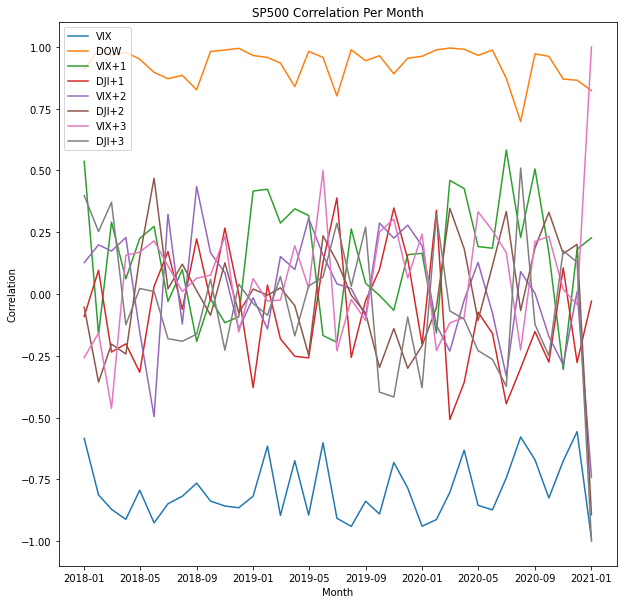

In [13]:
for x in range(len(monthly_df.columns)):
    plt.plot(monthly_df[monthly_df.columns[x]], label=monthly_df.columns[x])
plt.xlabel('Month')
plt.ylabel('Correlation')
plt.title('SP500 Correlation Per Month')
plt.legend()
plt.show()